In [117]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA

In [118]:
# Función para leer el archivo summary.csv de un equipo
def read_team_summary(team):
    base_path = '/Users/pgule/Documents/soccer_defense_analysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    return pd.read_csv(team_data_path)

In [119]:
# Función para escribir el archivo summary.csv de un equipo
def write_team_summary(team, df):
    base_path = '/Users/pgule/Documents/soccer_defense_analysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    df.to_csv(team_data_path, index=False)
    print(f"Archivo {team}_summary.csv actualizado correctamente.")

In [120]:
# Función para intercambiar jugadores en los archivos summary.csv
def swap_players_in_summary(player1, team1, player2, team2):
    # Leer el summary de cada equipo
    df_team1 = read_team_summary(team1)
    df_team2 = read_team_summary(team2)

    # Extraer la fila del jugador 1 de team1 y del jugador 2 de team2
    player1_row = df_team1[df_team1['PlayerName'] == player1]
    player2_row = df_team2[df_team2['PlayerName'] == player2]

    # Verificar si los jugadores existen en sus respectivos equipos
    if player1_row.empty or player2_row.empty:
        print("Error: No se encontró uno de los jugadores en los equipos respectivos.")
        return

    # Eliminar la fila de cada jugador en su equipo actual
    df_team1 = df_team1[df_team1['PlayerName'] != player1]
    df_team2 = df_team2[df_team2['PlayerName'] != player2]

    # Cambiar el equipo en la fila antes de agregar al nuevo equipo
    player1_row['Team'] = team2
    player2_row['Team'] = team1

    # Agregar la fila del jugador 1 al equipo 2 y la fila del jugador 2 al equipo 1
    df_team1 = pd.concat([df_team1, player2_row], ignore_index=True)
    df_team2 = pd.concat([df_team2, player1_row], ignore_index=True)

    # Guardar los archivos summary.csv actualizados
    write_team_summary(team1, df_team1)
    write_team_summary(team2, df_team2)
    print(f"Intercambio completado: {player1} de {team1} ↔ {player2} de {team2}")

# Ejemplo de uso
swap_players_in_summary('van Persie, Robin', 'Aston Villa', 'Agbonlahor, Gabriel', 'Manchester United')
swap_players_in_summary('Ferdinand, Rio', 'Aston Villa', 'Clark, Ciaran', 'Manchester United')
swap_players_in_summary('Carrick, Michael', 'Aston Villa', 'Bennett, Joe', 'Manchester United')
# swap_players_in_summary('van Persie, Robin', 'Manchester United', 'Agbonlahor, Gabriel', 'Aston Villa')
# swap_players_in_summary('Ferdinand, Rio', 'Manchester United', 'Clark, Ciaran', 'Aston Villa')
# swap_players_in_summary('Carrick, Michael', 'Manchester United', 'Bennett, Joe', 'Aston Villa')



Archivo Aston Villa_summary.csv actualizado correctamente.
Archivo Manchester United_summary.csv actualizado correctamente.
Intercambio completado: van Persie, Robin de Aston Villa ↔ Agbonlahor, Gabriel de Manchester United
Archivo Aston Villa_summary.csv actualizado correctamente.
Archivo Manchester United_summary.csv actualizado correctamente.
Intercambio completado: Ferdinand, Rio de Aston Villa ↔ Clark, Ciaran de Manchester United
Archivo Aston Villa_summary.csv actualizado correctamente.
Archivo Manchester United_summary.csv actualizado correctamente.
Intercambio completado: Carrick, Michael de Aston Villa ↔ Bennett, Joe de Manchester United


In [121]:
def get_initial_11(team):
    base_path = '/Users/pgule/Documents/soccer_defense_analysis/src/data'

    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'][:11].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [122]:
def get_team_players(team):
    base_path = '/Users/pgule/Documents/soccer_defense_analysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [123]:
def load_player_matrix(team_name, player_name, matrix_name):
    base_path = '/Users/pgule/Documents/soccer_defense_analysis/src/data'
    if matrix_name != 'pass_transition_matrix':
        matrix_path = os.path.join(base_path, team_name, player_name, f'{matrix_name}.csv')
        matrix = np.loadtxt(matrix_path, delimiter=',')
    else:
        matrix_path = os.path.join(base_path, team_name, player_name, f'{matrix_name}.npy')
        matrix = np.load(matrix_path)
    return matrix

In [124]:
def aggregate_team_matrices(team, players):
    team_matrixes = {
        'pass_matrix':  np.zeros((10, 10)),
        'shot_matrix': np.zeros((10, 10)),
        'defense_matrix': np.zeros((10, 10)),
        'goal_matrix': np.zeros((10, 10)),
        'errors_matrix': np.zeros((10, 10)),
        'out_matrix': np.zeros((10, 10))
    }

    for player in players:
        team_matrixes['pass_matrix'] += load_player_matrix(team, player, 'pass_matrix')
        team_matrixes['shot_matrix'] += load_player_matrix(team, player, 'shot_matrix')
        team_matrixes['defense_matrix'] += load_player_matrix(team, player, 'defense_matrix')
        team_matrixes['goal_matrix'] += load_player_matrix(team, player, 'goal_matrix')
        team_matrixes['errors_matrix'] += load_player_matrix(team, player, 'errors_matrix')
        team_matrixes['out_matrix'] += load_player_matrix(team, player, 'out_matrix') 
    
    return team_matrixes

In [125]:
teams_list = ['Arsenal', 'Everton', 'Fulham', 'Manchester City',
       'Newcastle United', 'Queens Park Rangers', 'Reading',
       'West Bromwich Albion', 'West Ham United', 'Wigan Athletic',
       'Aston Villa', 'Chelsea', 'Liverpool', 'Manchester United',
       'Norwich City', 'Southampton', 'Stoke City', 'Sunderland',
       'Swansea City', 'Tottenham Hotspur']

In [126]:
import os
import shutil

def move_player_folder(player, current_team, new_team):
    base_path = '/Users/pgule/Documents/soccer_defense_analysis/src/data'
    current_path = os.path.join(base_path, current_team, player)
    new_path = os.path.join(base_path, new_team, player)
    
    try:
        shutil.move(current_path, new_path)
        print(f"Carpeta de {player} movida de {current_team} a {new_team}.")
    except FileNotFoundError:
        print(f"No se encontró la carpeta para {player} en {current_team}.")
    except Exception as e:
        print(f"Error al mover la carpeta de {player}: {str(e)}")

In [127]:
def swap_players_and_move_folders(player1, team1, player2, team2):
    # Mover las carpetas de los jugadores en el sistema de archivos
    move_player_folder(player1, team1, team2)
    move_player_folder(player2, team2, team1)
    print(f"Intercambio completado y carpetas movidas para: {player1} de {team1} ↔ {player2} de {team2}")

In [128]:
base_path = '/Users/pgule/Documents/soccer_defense_analysis/src/data'

team_matrixes = {}
player_matrixes = {}
all_players = []


swap_players_and_move_folders('van Persie, Robin', 'Aston Villa', 'Agbonlahor, Gabriel', 'Manchester United')
swap_players_and_move_folders('Ferdinand, Rio', 'Aston Villa', 'Clark, Ciaran', 'Manchester United')
swap_players_and_move_folders('Carrick, Michael', 'Aston Villa', 'Bennett, Joe', 'Manchester United')
# swap_players_and_move_folders('van Persie, Robin', 'Manchester United', 'Agbonlahor, Gabriel', 'Aston Villa')
# swap_players_and_move_folders('Ferdinand, Rio', 'Manchester United', 'Clark, Ciaran', 'Aston Villa')
# swap_players_and_move_folders('Carrick, Michael', 'Manchester United', 'Bennett, Joe', 'Aston Villa')


for team in teams_list:
    team_csv_path = os.path.join(base_path, f"{team}/{team}_summary.csv")
    team_data = pd.read_csv(team_csv_path)
    
    players = get_initial_11(team)

    
    for player in players:
        if player not in player_matrixes:
            player_matrixes[player] = {}
        
        types = {
           
            'pass_matrix':  np.zeros((10, 10)),
            'shot_matrix': np.zeros((10, 10)),
            'defense_matrix': np.zeros((10, 10)),
            'goal_matrix': np.zeros((10, 10)),
            'errors_matrix': np.zeros((10, 10)),
            'out_matrix': np.zeros((10, 10))
        }
        
        all_players.append(player)
        
        for type_name in types:
            
            player_matrixes[player][type_name] = load_player_matrix(team, player, type_name)
        
        player_info = team_data[team_data['PlayerName'] == player]
        if not player_info.empty:
            position = player_info['Position'].values[0]
            cards = player_info['Cards'].values[0]
            time_played = player_info['MinutesPlayed'].values[0]
            player_matrixes[player]['team'] = team
            player_matrixes[player]['position'] = position
            player_matrixes[player]['cards'] = cards
            player_matrixes[player]['time'] = time_played

    team_matrixes[team] = aggregate_team_matrices(team, players)

Carpeta de van Persie, Robin movida de Aston Villa a Manchester United.
Carpeta de Agbonlahor, Gabriel movida de Manchester United a Aston Villa.
Intercambio completado y carpetas movidas para: van Persie, Robin de Aston Villa ↔ Agbonlahor, Gabriel de Manchester United
Carpeta de Ferdinand, Rio movida de Aston Villa a Manchester United.
Carpeta de Clark, Ciaran movida de Manchester United a Aston Villa.
Intercambio completado y carpetas movidas para: Ferdinand, Rio de Aston Villa ↔ Clark, Ciaran de Manchester United
Carpeta de Carrick, Michael movida de Aston Villa a Manchester United.
Carpeta de Bennett, Joe movida de Manchester United a Aston Villa.
Intercambio completado y carpetas movidas para: Carrick, Michael de Aston Villa ↔ Bennett, Joe de Manchester United


In [129]:
for team in teams_list:
    for matrix in team_matrixes[f'{team}']:
        team_matrixes[f'{team}'][matrix] = np.sum(team_matrixes[f'{team}'][matrix] * 90)

for player in all_players:
    for matrix_name, matrix_value in player_matrixes[f'{player}'].items():
        if matrix_name == 'cards':
            player_matrixes[f'{player}'][matrix_name] = matrix_value * 90
        elif matrix_name == 'time':
            player_matrixes[f'{player}'][matrix_name] = matrix_value / 90
        elif matrix_name == 'position' or matrix_name == 'team':
            pass
        else:
            player_matrixes[f'{player}'][matrix_name] = np.sum(matrix_value * 90)

player_dataframe = pd.DataFrame(player_matrixes).T

In [130]:
for player in all_players:
    for matrix_name, matrix_value in player_matrixes[f'{player}'].items():
        if matrix_name == 'cards':
            player_matrixes[f'{player}'][matrix_name] = matrix_value * 90
        elif matrix_name == 'time':
            player_matrixes[f'{player}'][matrix_name] = matrix_value / 90
        elif matrix_name == 'position' or matrix_name == 'team':
            pass
        else:
            player_matrixes[f'{player}'][matrix_name] = np.sum(matrix_value * 90)

In [131]:
player_dataframe = pd.DataFrame(player_matrixes).T

In [132]:
player_dataframe

,pass_matrix,shot_matrix,defense_matrix,goal_matrix,errors_matrix,out_matrix,team,position,cards,time
"Cazorla, Santiago",5094.1629,271.9899,912.9672,28.3824,338.2236,253.0764,Arsenal,Midfielder,2.364964,0.42284
"Mertesacker, Per",3954.8169,43.1568,946.8252,7.6059,388.3626,121.7673,Arsenal,Defender,10.153557,0.393951
"Arteta, Mikel",6589.5282,49.5558,1212.9588,15.6492,380.8053,143.451,Arsenal,Midfielder,15.652174,0.383333
"Giroud, Olivier",1480.7691,352.8765,695.7981,36.2718,695.8305,280.2195,Arsenal,Striker,13.192182,0.30321
"Walcott, Theo",1535.112,295.4637,414.3231,47.547,207.1413,193.5171,Arsenal,Striker,10.188679,0.294444
...,...,...,...,...,...,...,...,...,...,...
"Dembele, Mousa",4764.1122,82.3284,1063.0926,3.5802,332.9424,153.9486,Tottenham Hotspur,Midfielder,14.317278,0.279383
"Dawson, Michael",3443.0103,34.4817,1459.2069,3.8313,819.6066,256.6404,Tottenham Hotspur,Defender,15.319149,0.261111
"Dempsey, Clint",2428.0722,273.2697,737.8533,27.3294,651.9771,230.3478,Tottenham Hotspur,Striker,15.614458,0.256173
"Guimaraes Cordeiro, Sandro Ranieri",3522.8844,109.8036,1401.2352,4.3902,557.8551,175.6566,Tottenham Hotspur,Midfielder,17.570499,0.227654


In [133]:
for team in teams_list:
    team_stats = team_matrixes[team]
    for player in get_initial_11(team):
        if player in player_dataframe.index:
            for stat_name, stat_value in team_stats.items():
                player_dataframe.loc[player, f'{stat_name}_team'] = stat_value

In [134]:
metrics = ['pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 'errors_matrix', 'out_matrix']

for metric in metrics:
    player_dataframe[f'{metric}_contribution'] = player_dataframe[metric] / player_dataframe[f'{metric}_team']

In [135]:
player_dataframe = player_dataframe.round(2)

In [136]:
player_dataframe

,pass_matrix,shot_matrix,defense_matrix,goal_matrix,errors_matrix,out_matrix,team,position,cards,time,...,defense_matrix_team,goal_matrix_team,errors_matrix_team,out_matrix_team,pass_matrix_contribution,shot_matrix_contribution,defense_matrix_contribution,goal_matrix_contribution,errors_matrix_contribution,out_matrix_contribution
"Cazorla, Santiago",5094.1629,271.9899,912.9672,28.3824,338.2236,253.0764,Arsenal,Midfielder,2.364964,0.42284,...,102.83,2.03,47.92,25.71,11.345024,16.490203,8.878207,13.957688,7.057935,9.843627
"Mertesacker, Per",3954.8169,43.1568,946.8252,7.6059,388.3626,121.7673,Arsenal,Defender,10.153557,0.393951,...,102.83,2.03,47.92,25.71,8.807628,2.61651,9.207462,3.740374,8.104219,4.736245
"Arteta, Mikel",6589.5282,49.5558,1212.9588,15.6492,380.8053,143.451,Arsenal,Midfielder,15.652174,0.383333,...,102.83,2.03,47.92,25.71,14.675297,3.004469,11.795495,7.695848,7.946516,5.579652
"Giroud, Olivier",1480.7691,352.8765,695.7981,36.2718,695.8305,280.2195,Arsenal,Striker,13.192182,0.30321,...,102.83,2.03,47.92,25.71,3.297767,21.394195,6.766333,17.837479,14.520355,10.899381
"Walcott, Theo",1535.112,295.4637,414.3231,47.547,207.1413,193.5171,Arsenal,Striker,10.188679,0.294444,...,102.83,2.03,47.92,25.71,3.418792,17.913372,4.029111,23.382314,4.322554,7.527016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Dembele, Mousa",4764.1122,82.3284,1063.0926,3.5802,332.9424,153.9486,Tottenham Hotspur,Midfielder,14.317278,0.279383,...,104.29,1.97,55.59,27.36,14.3483,4.260246,10.193583,1.815858,5.989353,5.626332
"Dawson, Michael",3443.0103,34.4817,1459.2069,3.8313,819.6066,256.6404,Tottenham Hotspur,Defender,15.319149,0.261111,...,104.29,1.97,55.59,27.36,10.369475,1.784324,13.991769,1.943214,14.744032,9.379391
"Dempsey, Clint",2428.0722,273.2697,737.8533,27.3294,651.9771,230.3478,Tottenham Hotspur,Striker,15.614458,0.256173,...,104.29,1.97,55.59,27.36,7.312739,14.140881,7.074989,13.861323,11.728519,8.41848
"Guimaraes Cordeiro, Sandro Ranieri",3522.8844,109.8036,1401.2352,4.3902,557.8551,175.6566,Tottenham Hotspur,Midfielder,17.570499,0.227654,...,104.29,1.97,55.59,27.36,10.610036,5.682004,13.435901,2.226686,10.035343,6.419691


In [137]:
player_dataframe = player_dataframe.reset_index().rename(columns={'index': 'player'})

In [138]:
ranking = pd.read_excel('/Users/pgule/Documents/soccer_defense_analysis/Ranking.xlsx')

In [139]:
player_dataframe = player_dataframe.merge(ranking[['Equipo', 'Posicion']], left_on='team', right_on='Equipo', how='left')
player_dataframe = player_dataframe.drop(columns=['Equipo'])
player_dataframe = player_dataframe.rename(columns={'Posicion': 'TeamRanking'})

In [140]:
player_dataframe.sort_values(by='goal_matrix_contribution', ascending=False)

,player,pass_matrix,shot_matrix,defense_matrix,goal_matrix,errors_matrix,out_matrix,team,position,cards,...,goal_matrix_team,errors_matrix_team,out_matrix_team,pass_matrix_contribution,shot_matrix_contribution,defense_matrix_contribution,goal_matrix_contribution,errors_matrix_contribution,out_matrix_contribution,TeamRanking
76,"Le Fondre, Adam",966.654,272.646,342.0468,59.4864,505.6344,213.1596,Reading,Striker,14.871481,...,1.21,57.54,28.99,4.311702,25.576644,3.712355,49.072685,8.78697,7.353668,19
135,"Suarez, Luis",2456.3817,493.4034,472.2705,60.6852,356.2218,379.9305,Liverpool,Striker,26.384365,...,1.43,43.98,29.97,5.660033,30.423365,4.116767,42.442248,8.099991,12.678664,7
87,"Lukaku, Romelu",1619.1414,375.7428,499.6242,65.8449,592.6365,271.0584,West Bromwich Albion,Striker,11.621234,...,1.55,49.68,27.08,5.649974,29.429653,5.25378,42.387601,11.928082,10.010636,8
200,"Perez Cuesta, Miguel",2305.3167,287.5176,747.5328,47.0529,572.4189,211.7583,Swansea City,Striker,15.682478,...,1.23,53.18,24.91,5.269368,22.825542,6.773105,38.270258,10.764235,8.499915,9
49,"Cabaye, Yohan",3484.6281,221.697,979.1766,22.1616,395.3124,365.7555,Newcastle United,Striker,29.562044,...,0.59,60.67,27.36,11.081853,22.565752,8.215359,37.720588,6.516159,13.370544,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,"Begovic, Asmir",0.0,0.0,0.0,0.0,0.0,0.0,Stoke City,Goalkeeper,0.0,...,0.83,53.45,32.66,0.0,0.0,0.0,0.0,0.0,0.0,13
16,"Distin, Sylvain",2353.6494,46.3644,1388.1456,0.0,613.6398,275.4972,Everton,Defender,5.454545,...,1.46,51.37,29.85,7.179837,2.670523,12.73809,0.0,11.945924,9.230491,6
181,"Cameron, Geoff",2092.6269,23.5224,1257.9624,0.0,461.5299,291.0654,Stoke City,Defender,14.69521,...,0.83,53.45,32.66,9.004552,2.482924,10.356722,0.0,8.635537,8.912816,13
182,"Whelan, Glenn",3215.1492,63.4959,1049.4846,0.0,408.2724,238.8528,Stoke City,Midfielder,12.098581,...,0.83,53.45,32.66,13.834754,6.702355,8.640338,0.0,7.639053,7.313996,13


In [141]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [142]:
X = player_dataframe.drop(columns=['player', 'team', 'TeamRanking'])
y = player_dataframe['TeamRanking']

In [143]:
player_dataframe

,player,pass_matrix,shot_matrix,defense_matrix,goal_matrix,errors_matrix,out_matrix,team,position,cards,...,goal_matrix_team,errors_matrix_team,out_matrix_team,pass_matrix_contribution,shot_matrix_contribution,defense_matrix_contribution,goal_matrix_contribution,errors_matrix_contribution,out_matrix_contribution,TeamRanking
0,"Cazorla, Santiago",5094.1629,271.9899,912.9672,28.3824,338.2236,253.0764,Arsenal,Midfielder,2.364964,...,2.03,47.92,25.71,11.345024,16.490203,8.878207,13.957688,7.057935,9.843627,4
1,"Mertesacker, Per",3954.8169,43.1568,946.8252,7.6059,388.3626,121.7673,Arsenal,Defender,10.153557,...,2.03,47.92,25.71,8.807628,2.61651,9.207462,3.740374,8.104219,4.736245,4
2,"Arteta, Mikel",6589.5282,49.5558,1212.9588,15.6492,380.8053,143.451,Arsenal,Midfielder,15.652174,...,2.03,47.92,25.71,14.675297,3.004469,11.795495,7.695848,7.946516,5.579652,4
3,"Giroud, Olivier",1480.7691,352.8765,695.7981,36.2718,695.8305,280.2195,Arsenal,Striker,13.192182,...,2.03,47.92,25.71,3.297767,21.394195,6.766333,17.837479,14.520355,10.899381,4
4,"Walcott, Theo",1535.112,295.4637,414.3231,47.547,207.1413,193.5171,Arsenal,Striker,10.188679,...,2.03,47.92,25.71,3.418792,17.913372,4.029111,23.382314,4.322554,7.527016,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,"Dembele, Mousa",4764.1122,82.3284,1063.0926,3.5802,332.9424,153.9486,Tottenham Hotspur,Midfielder,14.317278,...,1.97,55.59,27.36,14.3483,4.260246,10.193583,1.815858,5.989353,5.626332,5
216,"Dawson, Michael",3443.0103,34.4817,1459.2069,3.8313,819.6066,256.6404,Tottenham Hotspur,Defender,15.319149,...,1.97,55.59,27.36,10.369475,1.784324,13.991769,1.943214,14.744032,9.379391,5
217,"Dempsey, Clint",2428.0722,273.2697,737.8533,27.3294,651.9771,230.3478,Tottenham Hotspur,Striker,15.614458,...,1.97,55.59,27.36,7.312739,14.140881,7.074989,13.861323,11.728519,8.41848,5
218,"Guimaraes Cordeiro, Sandro Ranieri",3522.8844,109.8036,1401.2352,4.3902,557.8551,175.6566,Tottenham Hotspur,Midfielder,17.570499,...,1.97,55.59,27.36,10.610036,5.682004,13.435901,2.226686,10.035343,6.419691,5


In [144]:
X = pd.get_dummies(X, columns=['position'], prefix='position')

In [145]:
X = X.drop(columns = ['pass_matrix_team',
       'shot_matrix_team', 'defense_matrix_team', 'goal_matrix_team',
       'errors_matrix_team', 'out_matrix_team'])

In [146]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Generalized prediction

In [147]:
player_dataframe

,player,pass_matrix,shot_matrix,defense_matrix,goal_matrix,errors_matrix,out_matrix,team,position,cards,...,goal_matrix_team,errors_matrix_team,out_matrix_team,pass_matrix_contribution,shot_matrix_contribution,defense_matrix_contribution,goal_matrix_contribution,errors_matrix_contribution,out_matrix_contribution,TeamRanking
0,"Cazorla, Santiago",5094.1629,271.9899,912.9672,28.3824,338.2236,253.0764,Arsenal,Midfielder,2.364964,...,2.03,47.92,25.71,11.345024,16.490203,8.878207,13.957688,7.057935,9.843627,4
1,"Mertesacker, Per",3954.8169,43.1568,946.8252,7.6059,388.3626,121.7673,Arsenal,Defender,10.153557,...,2.03,47.92,25.71,8.807628,2.61651,9.207462,3.740374,8.104219,4.736245,4
2,"Arteta, Mikel",6589.5282,49.5558,1212.9588,15.6492,380.8053,143.451,Arsenal,Midfielder,15.652174,...,2.03,47.92,25.71,14.675297,3.004469,11.795495,7.695848,7.946516,5.579652,4
3,"Giroud, Olivier",1480.7691,352.8765,695.7981,36.2718,695.8305,280.2195,Arsenal,Striker,13.192182,...,2.03,47.92,25.71,3.297767,21.394195,6.766333,17.837479,14.520355,10.899381,4
4,"Walcott, Theo",1535.112,295.4637,414.3231,47.547,207.1413,193.5171,Arsenal,Striker,10.188679,...,2.03,47.92,25.71,3.418792,17.913372,4.029111,23.382314,4.322554,7.527016,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,"Dembele, Mousa",4764.1122,82.3284,1063.0926,3.5802,332.9424,153.9486,Tottenham Hotspur,Midfielder,14.317278,...,1.97,55.59,27.36,14.3483,4.260246,10.193583,1.815858,5.989353,5.626332,5
216,"Dawson, Michael",3443.0103,34.4817,1459.2069,3.8313,819.6066,256.6404,Tottenham Hotspur,Defender,15.319149,...,1.97,55.59,27.36,10.369475,1.784324,13.991769,1.943214,14.744032,9.379391,5
217,"Dempsey, Clint",2428.0722,273.2697,737.8533,27.3294,651.9771,230.3478,Tottenham Hotspur,Striker,15.614458,...,1.97,55.59,27.36,7.312739,14.140881,7.074989,13.861323,11.728519,8.41848,5
218,"Guimaraes Cordeiro, Sandro Ranieri",3522.8844,109.8036,1401.2352,4.3902,557.8551,175.6566,Tottenham Hotspur,Midfielder,17.570499,...,1.97,55.59,27.36,10.610036,5.682004,13.435901,2.226686,10.035343,6.419691,5


In [148]:
#imprimir todos los jugadores del aston villa
player_dataframe[player_dataframe['team']=='Aston Villa']


,player,pass_matrix,shot_matrix,defense_matrix,goal_matrix,errors_matrix,out_matrix,team,position,cards,...,goal_matrix_team,errors_matrix_team,out_matrix_team,pass_matrix_contribution,shot_matrix_contribution,defense_matrix_contribution,goal_matrix_contribution,errors_matrix_contribution,out_matrix_contribution,TeamRanking
110,"Lowton, Matthew",3351.8286,38.07,1106.2089,4.7628,549.5445,254.5587,Aston Villa,Midfielder,23.788546,...,1.57,59.52,28.1,11.85019,3.476617,9.757484,3.037539,9.233111,9.059238,15
111,"Guzan, Brad",0.0,0.0,0.0,0.0,0.0,0.0,Aston Villa,Goalkeeper,0.0,...,1.57,59.52,28.1,0.0,0.0,0.0,0.0,0.0,0.0,15
112,"Benteke, Christian",2029.0662,283.2489,1007.6562,51.7347,836.0577,225.9495,Aston Villa,Striker,24.512441,...,1.57,59.52,28.1,7.173642,25.866771,8.888185,32.99449,14.04693,8.041093,15
113,"Clark, Ciaran",1945.3122,39.8196,1350.9585,3.0618,735.2451,315.4626,Aston Villa,Defender,21.444781,...,1.57,59.52,28.1,6.877535,3.636394,11.916335,1.952703,12.353139,11.226687,15
114,"Westwood, Ashley",3616.2045,28.5849,908.8119,3.1752,228.7845,162.0324,Aston Villa,Midfielder,6.355434,...,1.57,59.52,28.1,12.784875,2.610422,8.016314,2.025026,3.843897,5.766411,15
115,"Vlaar, Ron",2065.5324,51.8724,1147.8834,9.72,590.1498,171.7767,Aston Villa,Defender,3.242594,...,1.57,59.52,28.1,7.302567,4.737076,10.12508,6.199059,9.915336,6.113191,15
116,"Weimann, Andreas",1938.492,216.9504,601.8624,24.4944,374.4144,262.44,Aston Villa,Striker,13.99568,...,1.57,59.52,28.1,6.853423,19.812279,5.308819,15.621628,6.290682,9.339718,15
117,"Agbonlahor, Gabriel",1767.3633,170.0109,460.4607,31.8735,396.6732,191.241,Aston Villa,Striker,14.167031,...,1.57,59.52,28.1,6.248407,15.525684,4.061564,20.327747,6.664661,6.805887,15
118,"Baker, Nathan",2097.7299,42.6627,1430.7759,7.7598,791.0298,356.7807,Aston Villa,Defender,15.509813,...,1.57,59.52,28.1,7.416399,3.89603,12.620377,4.948915,13.290399,12.697116,15
119,"Bennett, Joe",2524.6809,32.643,954.423,0.0,428.3037,293.8275,Aston Villa,Midfielder,16.314199,...,1.57,59.52,28.1,8.925859,2.981014,8.418633,0.0,7.196097,10.456737,15


In [149]:
player_dataframe[player_dataframe['team']=='Manchester United']


,player,pass_matrix,shot_matrix,defense_matrix,goal_matrix,errors_matrix,out_matrix,team,position,cards,...,goal_matrix_team,errors_matrix_team,out_matrix_team,pass_matrix_contribution,shot_matrix_contribution,defense_matrix_contribution,goal_matrix_contribution,errors_matrix_contribution,out_matrix_contribution,TeamRanking
143,"van Persie, Robin",2074.5882,349.8876,506.1852,64.5165,347.3523,270.4104,Manchester United,Striker,14.889706,...,2.06,50.53,28.23,4.694019,27.716394,4.235489,31.298027,6.874161,9.580379,1
144,"Evra, Patrice",3182.8464,55.7037,1157.166,10.1331,460.8738,306.4473,Manchester United,Defender,7.596124,...,2.06,50.53,28.23,7.201594,4.412576,9.68255,4.915735,9.12077,10.857131,1
145,"Carrick, Michael",6235.0317,45.7407,1158.5754,2.5434,307.4598,165.2076,Manchester United,Midfielder,7.622334,...,2.06,50.53,28.23,14.10755,3.623356,9.694343,1.233846,6.084681,5.853145,1
146,"de Gea, David",0.0,0.0,0.0,0.0,0.0,0.0,Manchester United,Goalkeeper,0.0,...,2.06,50.53,28.23,0.0,0.0,0.0,0.0,0.0,0.0,1
147,"Ferdinand, Rio",3893.022,6.6744,1242.0054,3.3372,497.4534,173.5425,Manchester United,Defender,6.677659,...,2.06,50.53,28.23,8.808456,0.528714,10.392441,1.618931,9.844687,6.148443,1
148,"da Silva, Rafael Pereira",4177.7613,70.5915,1149.4791,10.0845,524.3616,332.7885,Manchester United,Defender,23.526971,...,2.06,50.53,28.23,9.452715,5.591915,9.61823,4.892159,10.377205,11.790374,1
149,"Valencia, Luis Antonio",3488.4675,59.6565,944.0388,3.5073,435.1725,235.1268,Manchester United,Midfielder,21.057192,...,2.06,50.53,28.23,7.8931,4.725698,7.899215,1.70145,8.612137,8.330315,1
150,"Rooney, Wayne",3989.7765,337.9806,679.8654,50.5116,365.2452,256.4946,Manchester United,Striker,27.194245,...,2.06,50.53,28.23,9.027375,26.773179,5.688752,24.504017,7.228264,9.087355,1
151,"Evans, Jonny",4098.9564,48.9888,1400.2956,20.412,657.2745,220.4496,Manchester United,Defender,8.165323,...,2.06,50.53,28.23,9.274409,3.880654,11.716929,9.9022,13.007573,7.810316,1
152,"Vidic, Nemanja",3319.6959,57.6477,1724.6844,9.6066,610.1082,302.616,Manchester United,Defender,9.608541,...,2.06,50.53,28.23,7.511233,4.56657,14.431242,4.660321,12.074144,10.721392,1


In [150]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

In [151]:
# Fijar la semilla para reproducibilidad
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [152]:
# if ranking is 1 to 4 -> 1
# if ranking is 5 to 8 -> 2
# if ranking is 9 to 12 -> 3
# if ranking is 13 to 16 -> 4
# if ranking is 17 to 20 -> 5
player_dataframe['TeamRanking'] = player_dataframe['TeamRanking'].apply(lambda x: 1 if x <= 4 else (2 if x <= 8 else (3 if x <= 12 else (4 if x <= 16 else 5))))

In [153]:
X = player_dataframe.drop(columns=['player', 'team', 'TeamRanking'])
y = player_dataframe['TeamRanking']

In [154]:
X = pd.get_dummies(X, columns=['position'], prefix='position')
X = X.drop(columns = ['pass_matrix_team',
       'shot_matrix_team', 'defense_matrix_team', 'goal_matrix_team',
       'errors_matrix_team', 'out_matrix_team'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

Epoch 1/200


C:\Users\pgule\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 12.3874 - mae: 3.0627 - val_loss: 7.9001 - val_mae: 2.2662
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.3048 - mae: 2.5116 - val_loss: 5.8793 - val_mae: 1.8174
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.0853 - mae: 2.0632 - val_loss: 4.3741 - val_mae: 1.4969
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.7291 - mae: 1.8186 - val_loss: 3.4513 - val_mae: 1.2678
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5855 - mae: 1.5982 - val_loss: 3.0845 - val_mae: 1.1340
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7351 - mae: 1.3821 - val_loss: 3.0923 - val_mae: 1.1787
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.7947 - mae: 1.3590 - val_loss: 3.2038 - val_mae: 1.2120
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3614 - mae: 1.2149 - val_loss: 3.1753 - val_mae: 1.2094
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5314 - mae: 1.2575 - val

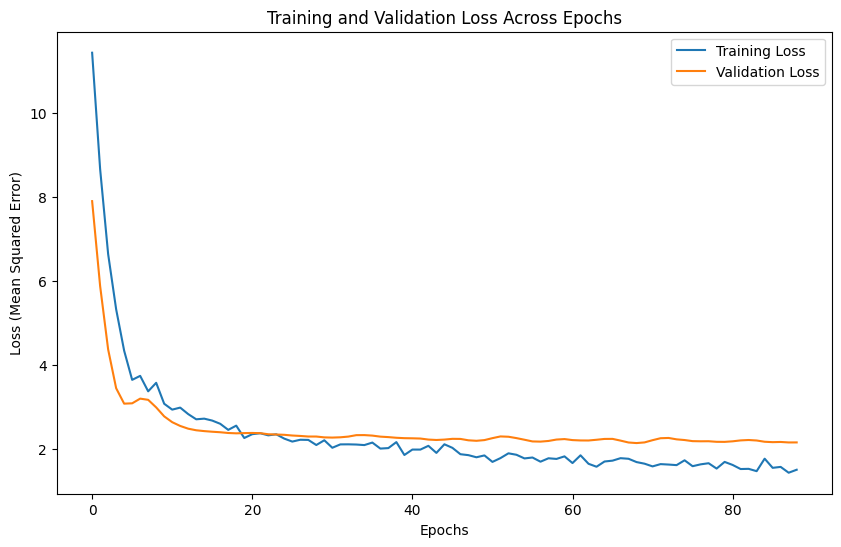

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=111)

# model = keras.Sequential([
#     layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
#     layers.Dropout(0.4),  # Adjust dropout
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(32, activation='relu'),
#     layers.Dense(1)  # Output layer
# ])
from tensorflow.keras import regularizers

model = keras.Sequential([
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(1)
])


model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
                    validation_split=0.2, callbacks=[early_stopping])

test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_mae}')

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.show()

In [156]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_mae}')

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.5472 - mae: 1.1091

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4423 - mae: 1.0648
Test MAE: 1.0730773210525513


In [157]:
team_rankings_pred = {}

for team in teams_list:
    players = get_initial_11(team)
    player_predictions = []

    for player in players:
        if player in player_matrixes:
            player_row = player_dataframe[player_dataframe['player'] == player].copy()
            required_columns = [
                'pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 
                'errors_matrix', 'out_matrix', 'cards', 'time',
                'pass_matrix_contribution', 'shot_matrix_contribution', 
                'defense_matrix_contribution', 'goal_matrix_contribution', 
                'errors_matrix_contribution', 'out_matrix_contribution'
            ]
            position_columns = [
                'position_Defender', 'position_Goalkeeper', 'position_Midfielder', 
                'position_Striker'
            ]

            player_position = player_row['position'].values[0]
            for pos_col in position_columns:
                player_row.loc[:, pos_col] = 1 if player_position in pos_col else 0

            # Select necessary columns
            player_row = player_row[required_columns + position_columns]

            # Convert to DataFrame with columns for scaler compatibility
            player_features = pd.DataFrame(player_row[required_columns + position_columns])
            player_features = scaler.transform(player_features)

            # Predict and collect
            player_prediction = model.predict(player_features)
            player_predictions.append(player_prediction[0])
        else:
            print(f"Player {player} not found in player_matrixes")

    # Average predictions
    if player_predictions:
        team_rankings_pred[team] = np.mean(player_predictions)
    else:
        print(f"No predictions for team {team}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

In [158]:
#create a df team and prediction
team_rankings_pred_df = pd.DataFrame(team_rankings_pred.items(), columns=['Team', 'PredictedRanking'])

In [159]:
team_rankings_pred_df.sort_values(by='PredictedRanking', ascending=True)
team_rankings_pred_df = team_rankings_pred_df.merge(ranking[['Equipo', 'Posicion']], left_on='Team', right_on='Equipo', how='left')
team_rankings_pred_df['Real'] = team_rankings_pred_df['Posicion'].apply(lambda x: 1 if x <= 4 else (2 if x <= 8 else (3 if x <= 12 else (4 if x <= 16 else 5))))

team_rankings_pred_df = team_rankings_pred_df.rename(columns={'PredictedRanking': 'Predicted'})
team_rankings_pred_df['Predicted'] = (team_rankings_pred_df['Predicted'].rank(method='min')).apply(lambda x: 1 if x <= 4 else (2 if x <= 8 else (3 if x <= 12 else (4 if x <= 16 else 5))))

team_rankings_pred_df['diff'] = team_rankings_pred_df['Real'] - team_rankings_pred_df['Predicted']
team_rankings_pred_df = team_rankings_pred_df[['Team', 'Predicted', 'Real', 'diff']]

In [160]:
team_rankings_pred_df.sort_values(by='Predicted', ascending=True)

,Team,Predicted,Real,diff
0,Arsenal,1,1,0
3,Manchester City,1,1,0
13,Manchester United,1,1,0
11,Chelsea,1,1,0
2,Fulham,2,3,1
12,Liverpool,2,2,0
18,Swansea City,2,3,1
19,Tottenham Hotspur,2,2,0
15,Southampton,3,4,1
9,Wigan Athletic,3,5,2
